In [0]:

import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize


In [45]:
# Carga de archivos desde drive
from google.colab import drive
drive.mount('drive', force_remount=True)

Mounted at drive


In [0]:
TRAIN_DIR = "/content/drive/My Drive/Colab Notebooks/data_x_ray/train/"
TEST_DIR =  "/content/drive/My Drive/Colab Notebooks/data_x_ray/test/"

In [0]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label



In [0]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [0]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [13]:
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████| 1342/1342 [18:47<00:00,  1.14it/s]


In [14]:
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 390/390 [02:28<00:00,  1.98it/s]


In [15]:
print(X_train.shape,'\n',X_test.shape)

(5129, 150, 150, 3) 
 (624, 150, 150, 3)


In [16]:
print(y_train.shape,'\n',y_test.shape)

(5129,) 
 (624,)


In [17]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

Using TensorFlow backend.


In [0]:
Pimages = os.listdir(TRAIN_DIR + "PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")

In [19]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.applications import imagenet_utils
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.tensorflow_backend.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report

In [0]:
# Se guarda unos datos por seguridad para las pruebas
X_trainRR=X_train
X_testRR=X_test

In [0]:
# Se realiza una transformación de las dimensiones de los datos
X_train=X_trainRR.reshape(5129,3,150,150)
X_test=X_testRR.reshape(624,3,150,150)

In [0]:
from keras.applications.inception_v3 import InceptionV3
# Se crea nuestro modelo en funcion de las capas de InceptionV3
base_model = InceptionV3(weights=None, include_top=False , input_shape=(3,150, 150))

In [0]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

In [0]:
# Se cargan los pesos originales de la red InceptionV3
base_model.load_weights("/content/drive/My Drive/Colab Notebooks/data_x_ray/inception_v3_weights.h5")

In [0]:
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

In [50]:
print(model.summary())
batch_size = 64
epochs = 10

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 3, 150, 150)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 32, 74, 74)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_190 (BatchN (None, 32, 74, 74)   96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 32, 74, 74)   0           batch_normalization_190[0][0]    
____________________________________________________________________________________________

In [51]:
# Se realiza el entrenamiento
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5129 samples, validate on 624 samples
Epoch 1/10
5129/5129 [==============================] - 1334s 260ms/step - loss: 0.3184 - acc: 0.8491 - val_loss: 0.4420 - val_acc: 0.8253

Epoch 00001: val_acc improved from -inf to 0.82532, saving model to transferlearning_weights.hdf5
Epoch 2/10
5129/5129 [==============================] - 1300s 253ms/step - loss: 0.1863 - acc: 0.9082 - val_loss: 1.6371 - val_acc: 0.6779

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00002: val_acc did not improve from 0.82532
Epoch 3/10
5129/5129 [==============================] - 1307s 255ms/step - loss: 0.1579 - acc: 0.9308 - val_loss: 0.6637 - val_acc: 0.7468

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00003: val_acc did not improve from 0.82532
Epoch 4/10
5129/5129 [==============================] - 1327s 259ms/step - lo

In [0]:
 # Guarda el entrenamiento para ejecutarlo cuando proceda
 model.save("/content/drive/My Drive/Colab Notebooks/data_x_ray/ModeloInceptionV3XRay")

In [0]:
RESULTADOS = model.predict(X_test, batch_size=64)

In [0]:
labelNames = ["PNEUMONIA","NORMAL"]

In [0]:
# Selecciona imagen CON PNEUMONIA y se lee con OPENCV
img_path = "/content/drive/My Drive/Colab Notebooks/data_x_ray/val/PNEUMONIA/person1952_bacteria_4883.jpeg" # Path de Drive donde tengo la imagen (incluido el nombre de la misma) #(X)
img_test = cv2.imread(img_path, cv2.IMREAD_COLOR) # Leo imagen con OPENCV


(952, 1192, 3)


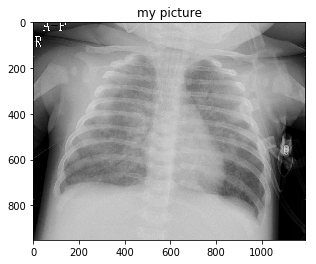

Predicción: PNEUMONIA - Confianza: 100.00% 


In [127]:
print(img_test.shape)
plt.imshow(img_test)
plt.title('my picture')
plt.show()

# Pre-procesamos tal y como he hecho para la fase de entrenamiento con las muestras de CIFAR10
img_test = img_test.astype("float") / 255.0 #(X)
# Re-escalamos la imagen al tamaño con el que fue entrenada la red (comando cv2.resize)
img_test_res = cv2.resize(img_test, (150, 150)) #(X)
#print(img_test_res.shape)
# Se añade una nueva dimension
img_test_res = np.moveaxis(img_test_res, -1, 0)
img_test_res = np.expand_dims(img_test_res, axis=0)
# Realizamos la prediccion y enseñamos por pantalla el resultado más grande
predi = model.predict(img_test_res)
idx = np.argmax(predi)
label = "Predicción: {} - Confianza: {:.2f}% ".format(labelNames[idx], predi[0][idx] * 100)

print(label)

# Predecimos la imagen pasando como parámetros a la función predict_image: la imagen, el modelo y string con el GT
#predict_image(img_test_res, model, "Normal")#(X)

In [0]:
# Selecciona imagen NORMAL y se lee con OPENCV
img_path2 = "/content/drive/My Drive/Colab Notebooks/data_x_ray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg" # Path de Drive donde tengo la imagen (incluido el nombre de la misma) #(X)
img_test2 = cv2.imread(img_path2, cv2.IMREAD_COLOR) # Leo imagen con OPENCV

(1040, 1272, 3)


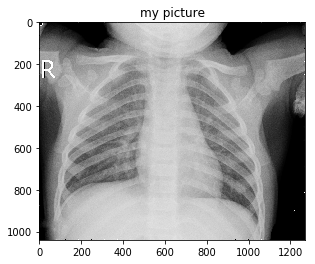

Predicción: NORMAL - Confianza: 72.38% 


In [129]:
print(img_test2.shape)
plt.imshow(img_test2)
plt.title('my picture')
plt.show()

# Pre-procesamos tal y como he hecho para la fase de entrenamiento con las muestras de CIFAR10
img_test2 = img_test2.astype("float") / 255.0 #(X)
# Re-escalamos la imagen al tamaño con el que fue entrenada la red (comando cv2.resize)
img_test2_res = cv2.resize(img_test2, (150, 150)) #(X)
# Se añade una nueva dimension
img_test2_res = np.moveaxis(img_test2_res, -1, 0)
img_test2_res = np.expand_dims(img_test2_res, axis=0)
# Realizamos la prediccion y enseñamos por pantalla el resultado más grande
predi2 = model.predict(img_test2_res)
idx = np.argmax(predi2)
label = "Predicción: {} - Confianza: {:.2f}% ".format(labelNames[idx], predi2[0][idx] * 100)

print(label)

# Predecimos la imagen pasando como parámetros a la función predict_image: la imagen, el modelo y string con el GT
#predict_image(img_test_res, model, "Normal")#(X)